# Project: Investigate "No Show Appointment" Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

In this project, I'll be analyzing data associated with the medical appointment in Barazil.This dataset collects information from 100k medical appointments and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.

#### List of columns:
<ul>
<li>‘PatientId’ tells us patient ID.</li>
<li>‘AppointmentID’ tells us appointment ID.</li>
<li>‘Gender’ tells us patient gender.</li>
<li>‘ScheduledDay’ tells us on what day the patient set up their appointment.</li>
<li>‘AppointmentDay’ tells us on what day the appointment is.</li>
<li>‘Age’ tells us the patient age.</li>
<li>‘Neighborhood’ indicates the location of the hospital.</li>
<li>‘Scholarshipc’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.</li>
<li>‘hypertension’ indicates whether or not the patient has high blood pressure.</li>
<li>‘Diabetes’ indicates whether or not the patient is diabetic.</li>
<li>‘Alcoholism’ indicates whether or not the patient is alcoholism.</li>
<li>‘Handicap’ indicates whether or not the patient is hanicap.*</li>
<li>‘SMS_received’ indicates whether or not the patient recived an SMS.</li>
<li>‘No_show’ indicates whether or not the patient showed to the appointment.</li>
</ul>

*Note: ‘Hancap’ column has 5 different values; 1, 2, 3, 4 for different impairments (I guess visual, hearing, motor and cognitive) and 0 for no impairments.

Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.


### Question(s) for Analysis

#### List of Questions to explore
<ol>
    <li>Q1. Does the age of the patient affect showing to the appointment?</li>
    <li>Q2. How recieving an SMS affect the result?</li>
    <li><ol>Q3. How does the appointment date affect the showing of the patient to the appointment?
        <li>Does the number of days apart affect the propability of the patient to show to the appointment?</li>
        <li>Which week days are most common?</li>
    </ol></li>
</ol>

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [45]:
# Upgrade pandas to use dataframe.explode() function. 
# !pip install --upgrade pandas==0.25.0

<a id='wrangling'></a>
## Data Wrangling


### General Properties


In [46]:
df = pd.read_csv('Database_No_show_appointments/noshowappointments-kagglev2-may-2016.csv')


### Data Cleaning

In [47]:
# check if there's any duplicated rows
sum(df.duplicated())

0

In [48]:
# check if there's any duplicated rows based on the AppointmentID coulmn only because two appointments can't have the same ID. 
sum(df.duplicated(subset=['AppointmentID']))

0

In [49]:
# drop 'patient ID' and 'appointment ID' columns as they aren't useful in Analyzing the dataset.
# also drop 'Neighbourhood' column because the name of the neighbourhood only without more information
# about it, like its economical state isn't useful.
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)
df.drop(['Neighbourhood'], axis=1, inplace=True)

In [50]:
# rename Hipertension and Handcap columns to fix the typo.
# rename columns to lowercase and add underscore (_) to be consistant.
df = df.rename(columns=str.lower)
df = df.rename(columns={"hipertension": "hypertension", "handcap": "handicap", "scheduledday": "scheduled_day", "appointmentday": "appointment_day", "no-show": "no_show"})
df.head(1)

,gender,scheduled_day,appointment_day,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,0,0,No


In [51]:
# convert scheduled day and appointment day from string to datatime type so math operations can be preformed on them.
df['scheduled_day'] = pd.to_datetime(df['scheduled_day'])
df['appointment_day'] = pd.to_datetime(df['appointment_day'])

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 11 columns):
gender             110527 non-null object
scheduled_day      110527 non-null datetime64[ns]
appointment_day    110527 non-null datetime64[ns]
age                110527 non-null int64
scholarship        110527 non-null int64
hypertension       110527 non-null int64
diabetes           110527 non-null int64
alcoholism         110527 non-null int64
handicap           110527 non-null int64
sms_received       110527 non-null int64
no_show            110527 non-null object
dtypes: datetime64[ns](2), int64(7), object(2)
memory usage: 9.3+ MB


###### Note:
Invistigating the age column, there's one negative value (-1) which will be replaced with the mean. Also, there're 3000+ values with 0 value, which I will assume the patient's age here is less than one year (from day 1 to less than 12 months).

In [53]:
df.loc[df['age'] < 0]

,gender,scheduled_day,appointment_day,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
99832,F,2016-06-06 08:58:13,2016-06-06,-1,0,0,0,0,0,0,No


In [54]:
# replace wrong value (-1) in 'age' with the mean.
df['age'].replace(-1, df['age'].mean(), inplace=True)
# check for the min age
df.describe()

,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.089219,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,23.109921,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [55]:
# Create a new column which is the number of days apart between scheduled day and appointment day.
df['days_apart'] = df['appointment_day'].dt.date - df['scheduled_day'].dt.date
df['days_apart'] = df['days_apart'] / np.timedelta64(1, 'D')
df['days_apart'] = df['days_apart'].astype(int)
df.head(1)

,gender,scheduled_day,appointment_day,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,days_apart
0,F,2016-04-29 18:38:08,2016-04-29,62.0,0,1,0,0,0,0,No,0


In [56]:
df['days_apart'].describe()

count    110527.000000
mean         10.183702
std          15.254996
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: days_apart, dtype: float64

In [57]:
df.loc[df['days_apart'] < 0]

,gender,scheduled_day,appointment_day,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,days_apart
27033,M,2016-05-10 10:51:53,2016-05-09,38.0,0,0,0,0,1,0,Yes,-1
55226,F,2016-05-18 14:50:41,2016-05-17,19.0,0,0,0,0,1,0,Yes,-1
64175,F,2016-05-05 13:43:58,2016-05-04,22.0,0,0,0,0,0,0,Yes,-1
71533,F,2016-05-11 13:49:20,2016-05-05,81.0,0,0,0,0,0,0,Yes,-6
72362,M,2016-05-04 06:50:57,2016-05-03,7.0,0,0,0,0,0,0,Yes,-1


In [58]:
# drop rows with negative value in days_apart column.
df.drop(df.loc[df['days_apart'] < 0].index, axis = 0, inplace=True)

In [59]:
df.describe()

,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,days_apart
count,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000
mean,37.089386,0.098270,0.197255,0.071868,0.030401,0.022231,0.321040,10.184253
std,23.109780,0.297681,0.397928,0.258270,0.171689,0.161493,0.466878,15.255115
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000


In [60]:
# replace Yes & No values in no_show with 1 & 0 for easier vasulization
df['no_show'].replace('Yes', 1, inplace=True)
df['no_show'].replace('No', 0, inplace=True)

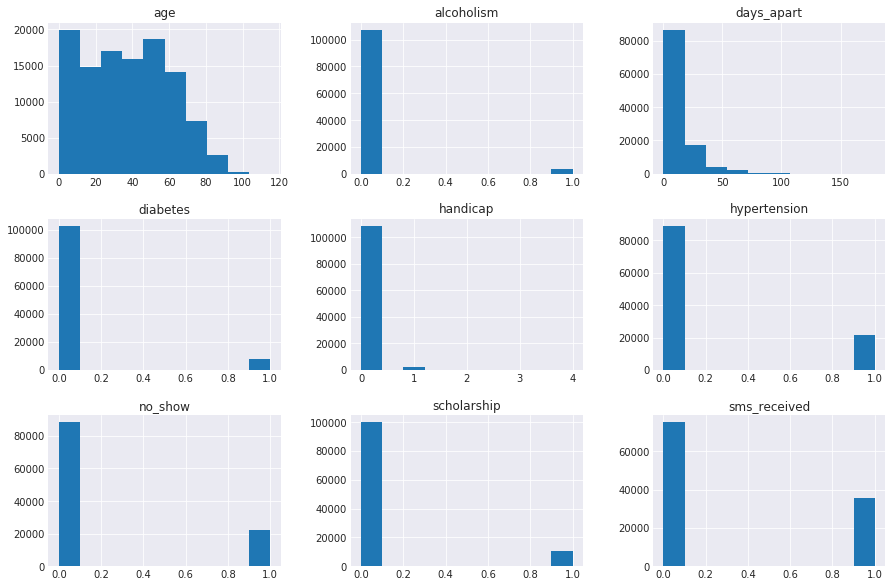

In [61]:
df.hist(figsize=(15,10));

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. 



> **Tip**: - Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.


### What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?
#### A. What is the percentage of people showing to the appointment?

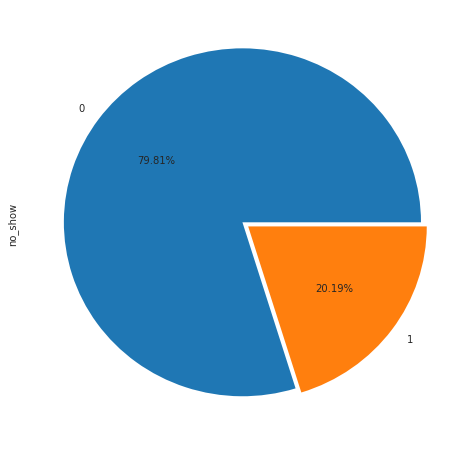

In [62]:
df['no_show'].value_counts().plot.pie(figsize=(8,8), autopct='%.2f%%', explode=(0.02,0.02));

###### Conclusion:
Almost 80% of the patients showed to the appointments.
#### B. Does the age of the patient affect showing to the appointment?

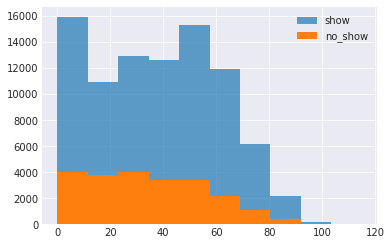

In [63]:
show = df.no_show == 0
no_show = df.no_show == 1
df.age[show].hist(alpha=0.7, label='show')
df.age[no_show].hist(label='no_show')
plt.legend();

###### Conclusion:
The above histogram shows the distributions of ages for the patients who showed to their appointments (blue) and who didn't (orange)

In [64]:
df.groupby('no_show').age.mean()

no_show
0    37.790496
1    34.317872
Name: age, dtype: float64

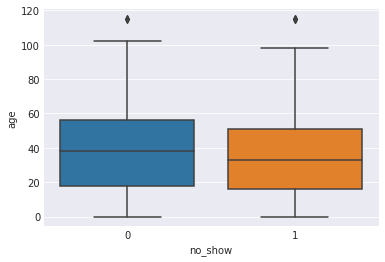

In [65]:
sns.boxplot(x=df.no_show, y=df.age);

###### conclusion:
The mean (average) age for the people who showed to their appointment are slightly higher than who didn't.
### Q2. How recieving an SMS affect the result?

In [66]:
colors = ['green', 'orange']

Text(0,0.5,'sms_received')

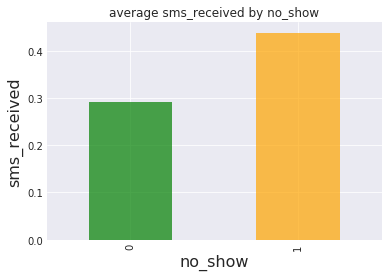

In [67]:
no_show_means = df.groupby('no_show')['sms_received'].mean()
no_show_means.plot(kind='bar', title='average sms_received by no_show', color=colors, alpha=0.7);
plt.xlabel('no_show', fontsize=16)
plt.ylabel('sms_received', fontsize=16)

##### Conclusion:
Suprisingly, the mean (average) of no shows is much higher whene sms were received.
### Research Question 2: How does the appointment date affect the showing of the patient to the appointment?
#### A. Does the number of days apart affect the propability of the patient to show to the appointment?

In [68]:
# Categorize the appointments to: same day appointments, near appointments (less than 4 days apart),
# mid-appointments (between 4 and 15 days apart) and far appoinments (more than 15).
bin_edges = [0, 0.9, 4, 15, 179]
bin_names = ['same_day', 'near', 'mid', 'far']
df['levels'] = pd.cut(df['days_apart'], bin_edges, labels=bin_names, include_lowest=True)
df.head(1)

,gender,scheduled_day,appointment_day,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,days_apart,levels
0,F,2016-04-29 18:38:08,2016-04-29,62.0,0,1,0,0,0,0,0,0,same_day


In [69]:
df.groupby('levels')['no_show'].mean()

levels
same_day    0.046469
near        0.229902
mid         0.285381
far         0.327059
Name: no_show, dtype: float64

In [70]:
df['levels'].value_counts()

same_day    38563
far         26246
mid         25748
near        19965
Name: levels, dtype: int64

###### Conclusion:
From the mean and counts, we can see that the more days apart, the less probability that the patient will show to the appointment. Let's create a bar chart to visualize this...

In [71]:
colors = ['green', 'orange']

Text(0,0.5,'days_apart')

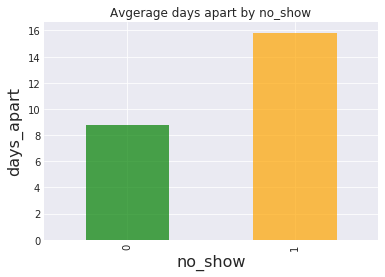

In [72]:
no_show_means = df.groupby('no_show')['days_apart'].mean()
no_show_means.plot(kind='bar', title='Avgerage days apart by no_show', color=colors, alpha=0.7);
plt.xlabel('no_show', fontsize=16)
plt.ylabel('days_apart', fontsize=16)

##### Conclusion:
In the above graph, the average days apart for people who showed to their appointment is 9 days, but more than 15 for who didn't. This shows us that increasing the average of days apart increases the probability that the patient won't show to the appointment. For more details, let's plot counts for each level of days_apart by the no_show column. But first, let's get porportions because there's more paient who showed than who didn't.

In [73]:
df.groupby(['no_show', 'levels']).count()['age']

no_show  levels  
0        same_day    36771
         near        15375
         mid         18400
         far         17662
1        same_day     1792
         near         4590
         mid          7348
         far          8584
Name: age, dtype: int64

In [74]:
no_show_counts = df.groupby(['no_show', 'levels']).count()['age']
no_show_counts

no_show  levels  
0        same_day    36771
         near        15375
         mid         18400
         far         17662
1        same_day     1792
         near         4590
         mid          7348
         far          8584
Name: age, dtype: int64

In [75]:
no_show_totals = df.groupby('no_show').count()['age']
no_show_totals

no_show
0    88208
1    22314
Name: age, dtype: int64

In [76]:
show_proportions = no_show_counts[0]/no_show_totals[0]
show_proportions

levels
same_day    0.416867
near        0.174304
mid         0.208598
far         0.200231
Name: age, dtype: float64

In [77]:
no_show_proportions = no_show_counts[1]/no_show_totals[1]
no_show_proportions

levels
same_day    0.080308
near        0.205700
mid         0.329300
far         0.384691
Name: age, dtype: float64

In [78]:
ind = np.arange(len(show_proportions))  # the x locations for the groups
width = 0.35       # the width of the bars

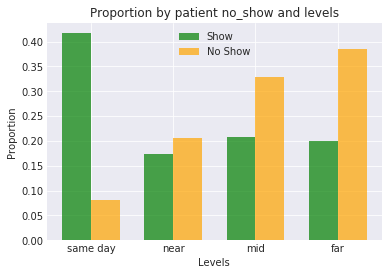

In [79]:
# plot bars
show_bars = plt.bar(ind, show_proportions, width, color='green', alpha=.7, label='Show')
no_show_bars = plt.bar(ind + width, no_show_proportions, width, color='orange', alpha=.7, label='No Show')

# title and labels
plt.ylabel('Proportion')
plt.xlabel('Levels')
plt.title('Proportion by patient no_show and levels')
locations = ind + width / 2  # xtick locations
labels = ['same day', 'near', 'mid', 'far']  # xtick labels
plt.xticks(locations, labels)

# legend
plt.legend()

##### Conclusion:
This detailed graph shows that it was more likely the patient will show to the appointment when it's scheduled in the same day. and the probability decreases with more days apart.
#### B. Which week days are most common?

In [80]:
# extract the weekday from the appointment_day coulmn
extract_day = lambda x: x.weekday_name
df['day_of_week'] = df['appointment_day'].apply(extract_day)
df.day_of_week.value_counts().to_frame(name='How Many Appointments')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  


,How Many Appointments
Wednesday,25866
Tuesday,25638
Monday,22714
Friday,19019
Thursday,17246
Saturday,39


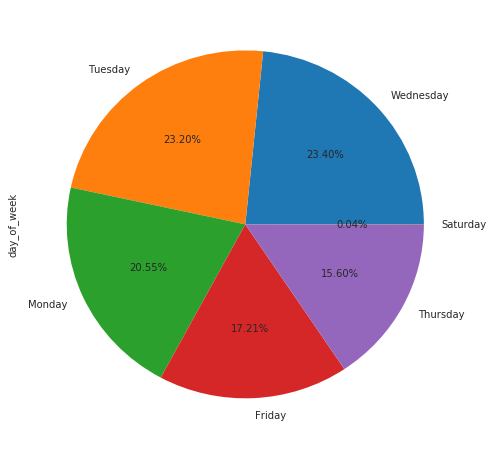

In [81]:
df['day_of_week'].value_counts().plot.pie(figsize=(8,8), autopct='%.2f%%');

###### Conclusion:
It's more likely patients will schedule an appointment in weekdays (Monday through Friday) than in the weekend (Saturdau/Sunday)

<a id='conclusions'></a>
## Conclusions

#### Q1. Does the age of the patient affect showing to the appointment?
The mean (average) age for the people who showed to their appointment are slightly higher than who didn't.
#### Q2. How recieving an SMS affect the result?
Unexpectedly, patients who recieved an SMS were more likely to not show to their appointments.
#### Q3. How does the appointment date affect the showing of the patient to the appointment?
It was more likely for people to show to their appointment if it's scheduled on the same day. Moreover, they scedule appointments more often in weekadys (Monday through Wednesday).

### Limitations
One limitation to this dataset is the missing informaion about the patients neighbourhood, more details about the neighbourhood would be nice to have like; its economical state, how far is the nearest hospital, or even the percentage of people who are unemployed in each neighbourhood. Overall, more statistical tests should be taken.

## Submitting your Project 

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [82]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0